<a href="https://colab.research.google.com/github/erlichsefi/ScrapAnything/blob/main/edge_detection_for_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


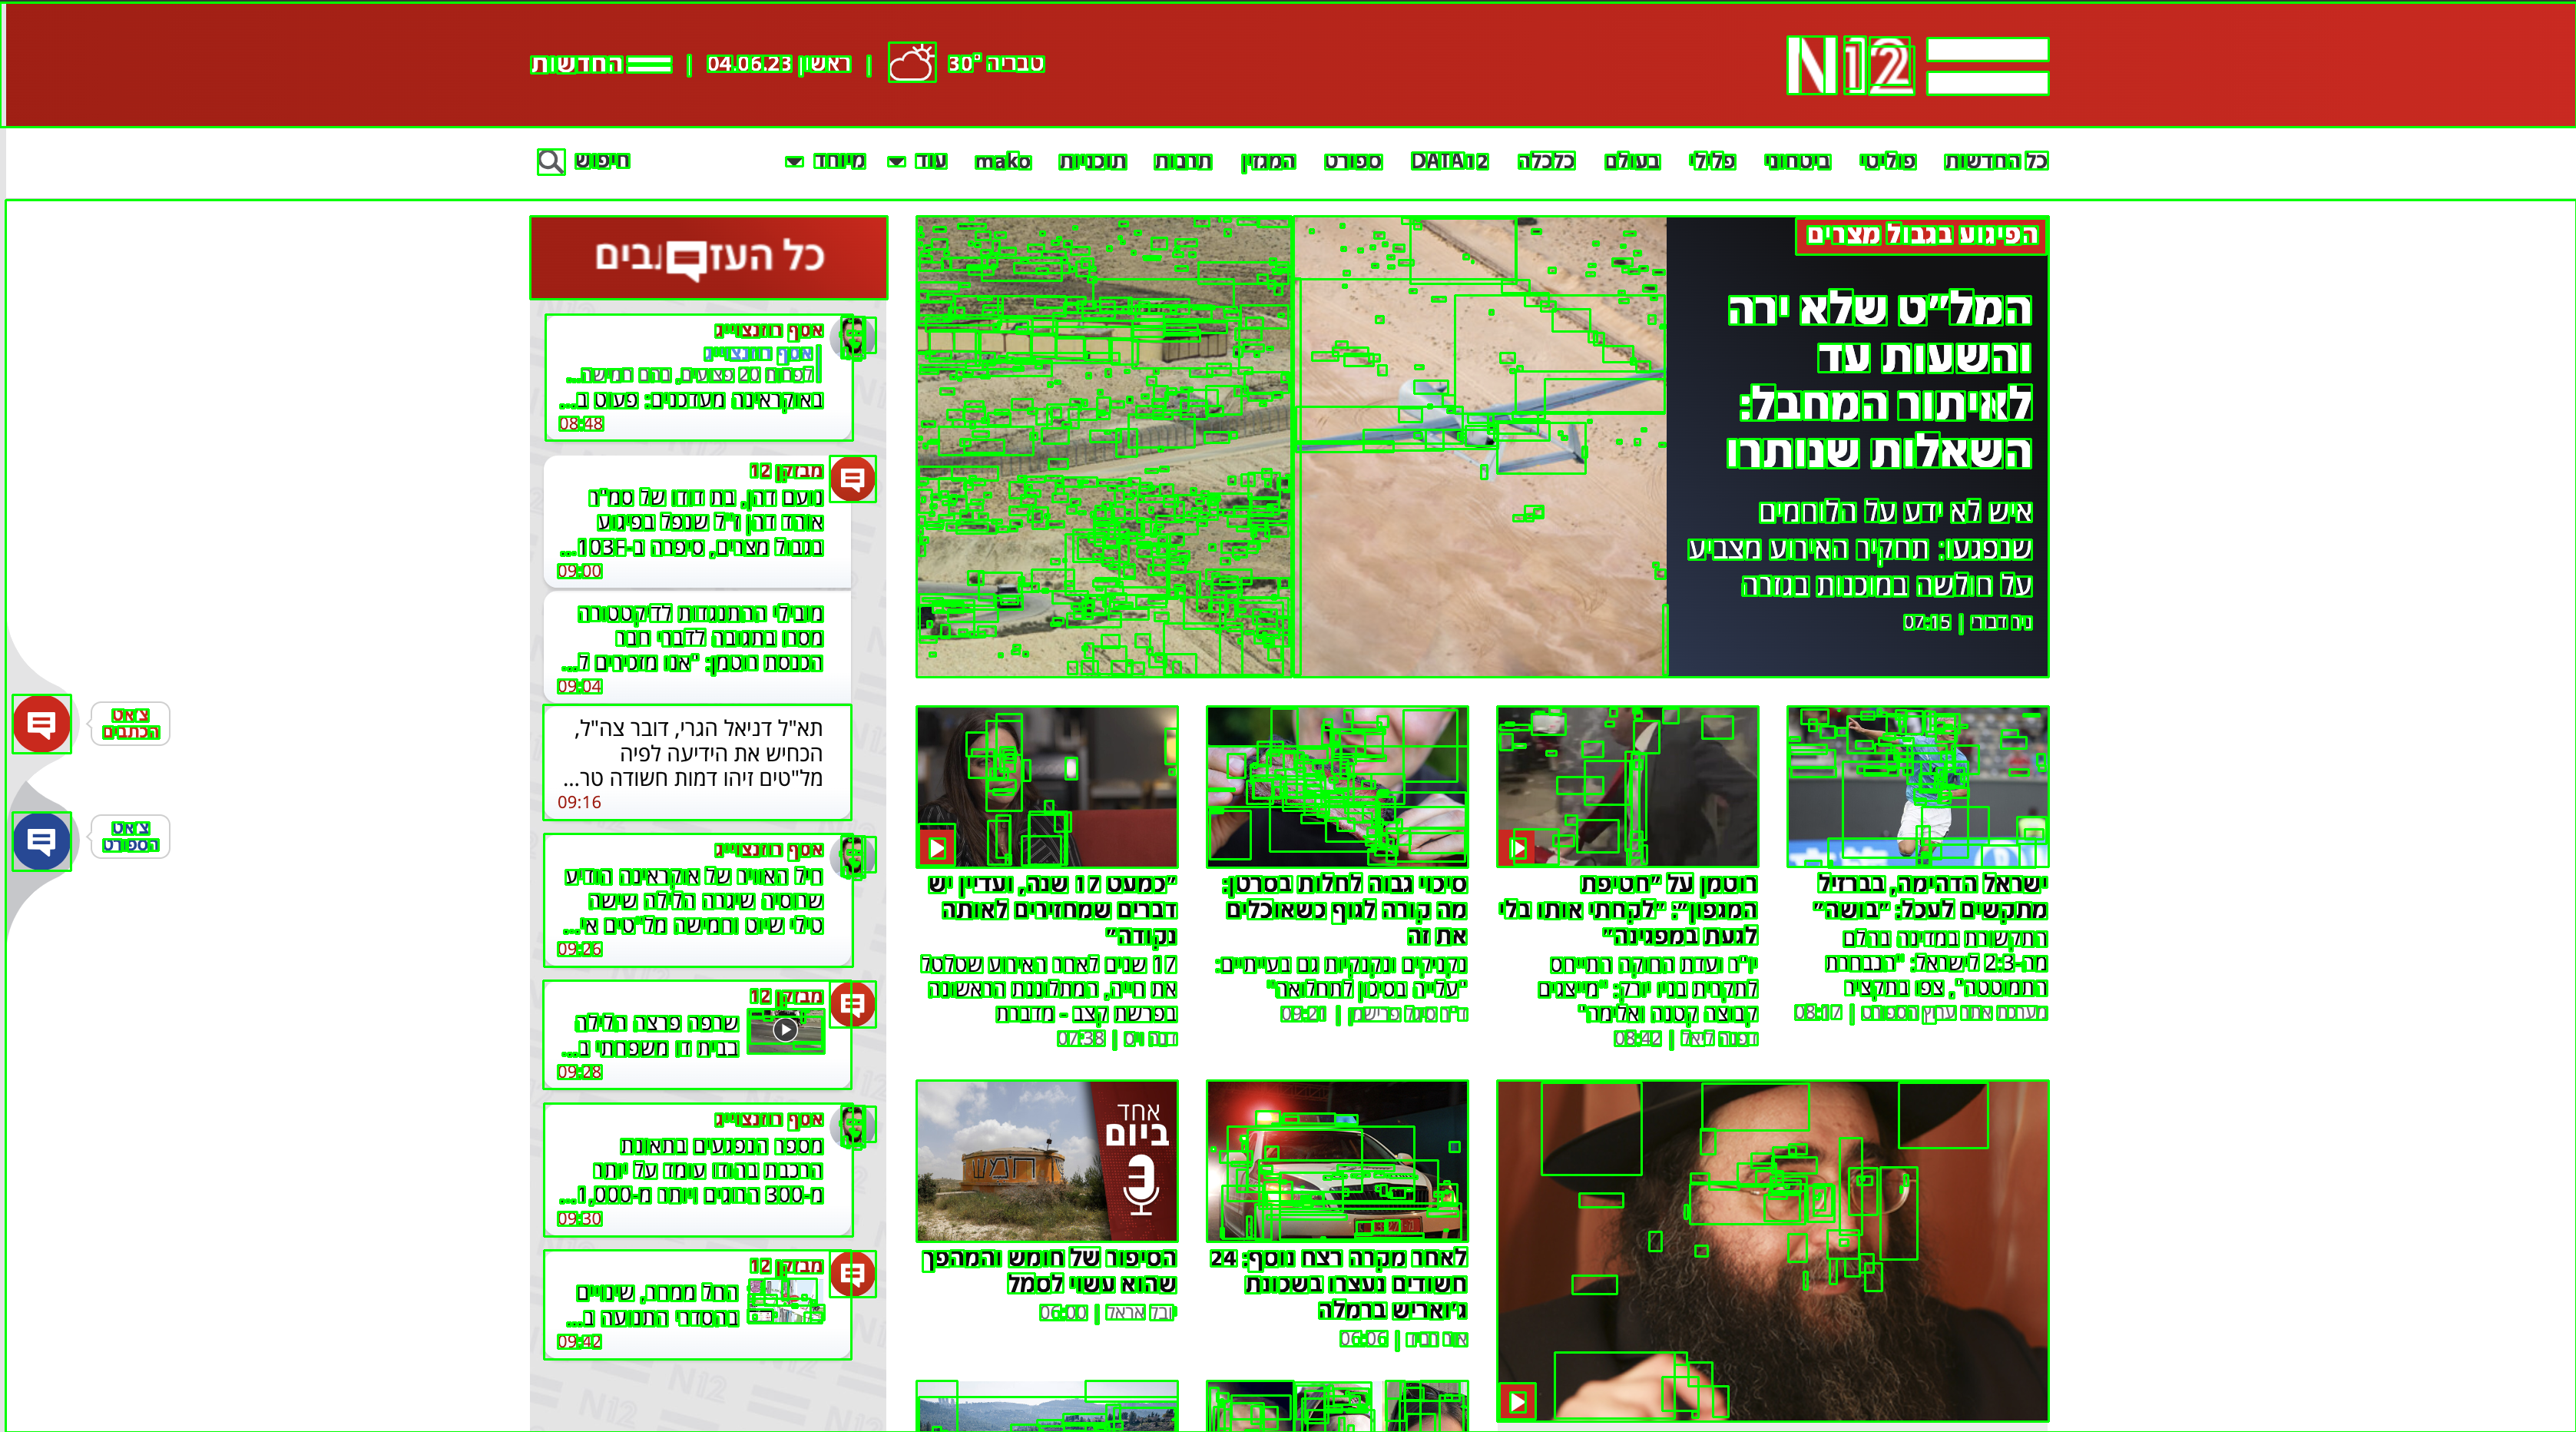

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_regions(image_path):
    # Load the screenshot image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours of the regions
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding rectangles around the regions
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with detected regions
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return contours

# Provide the path to your screenshot image
screenshot_path = "screen3.png"

# Call the function to detect and display the regions
contours = detect_regions(screenshot_path)


(1864, 3354, 3)
Number of boxes enter 1992
Number of boxes exits 183
Number of boxes enter 183
Number of boxes exits 68
Number of boxes enter 68
Number of boxes exits 68


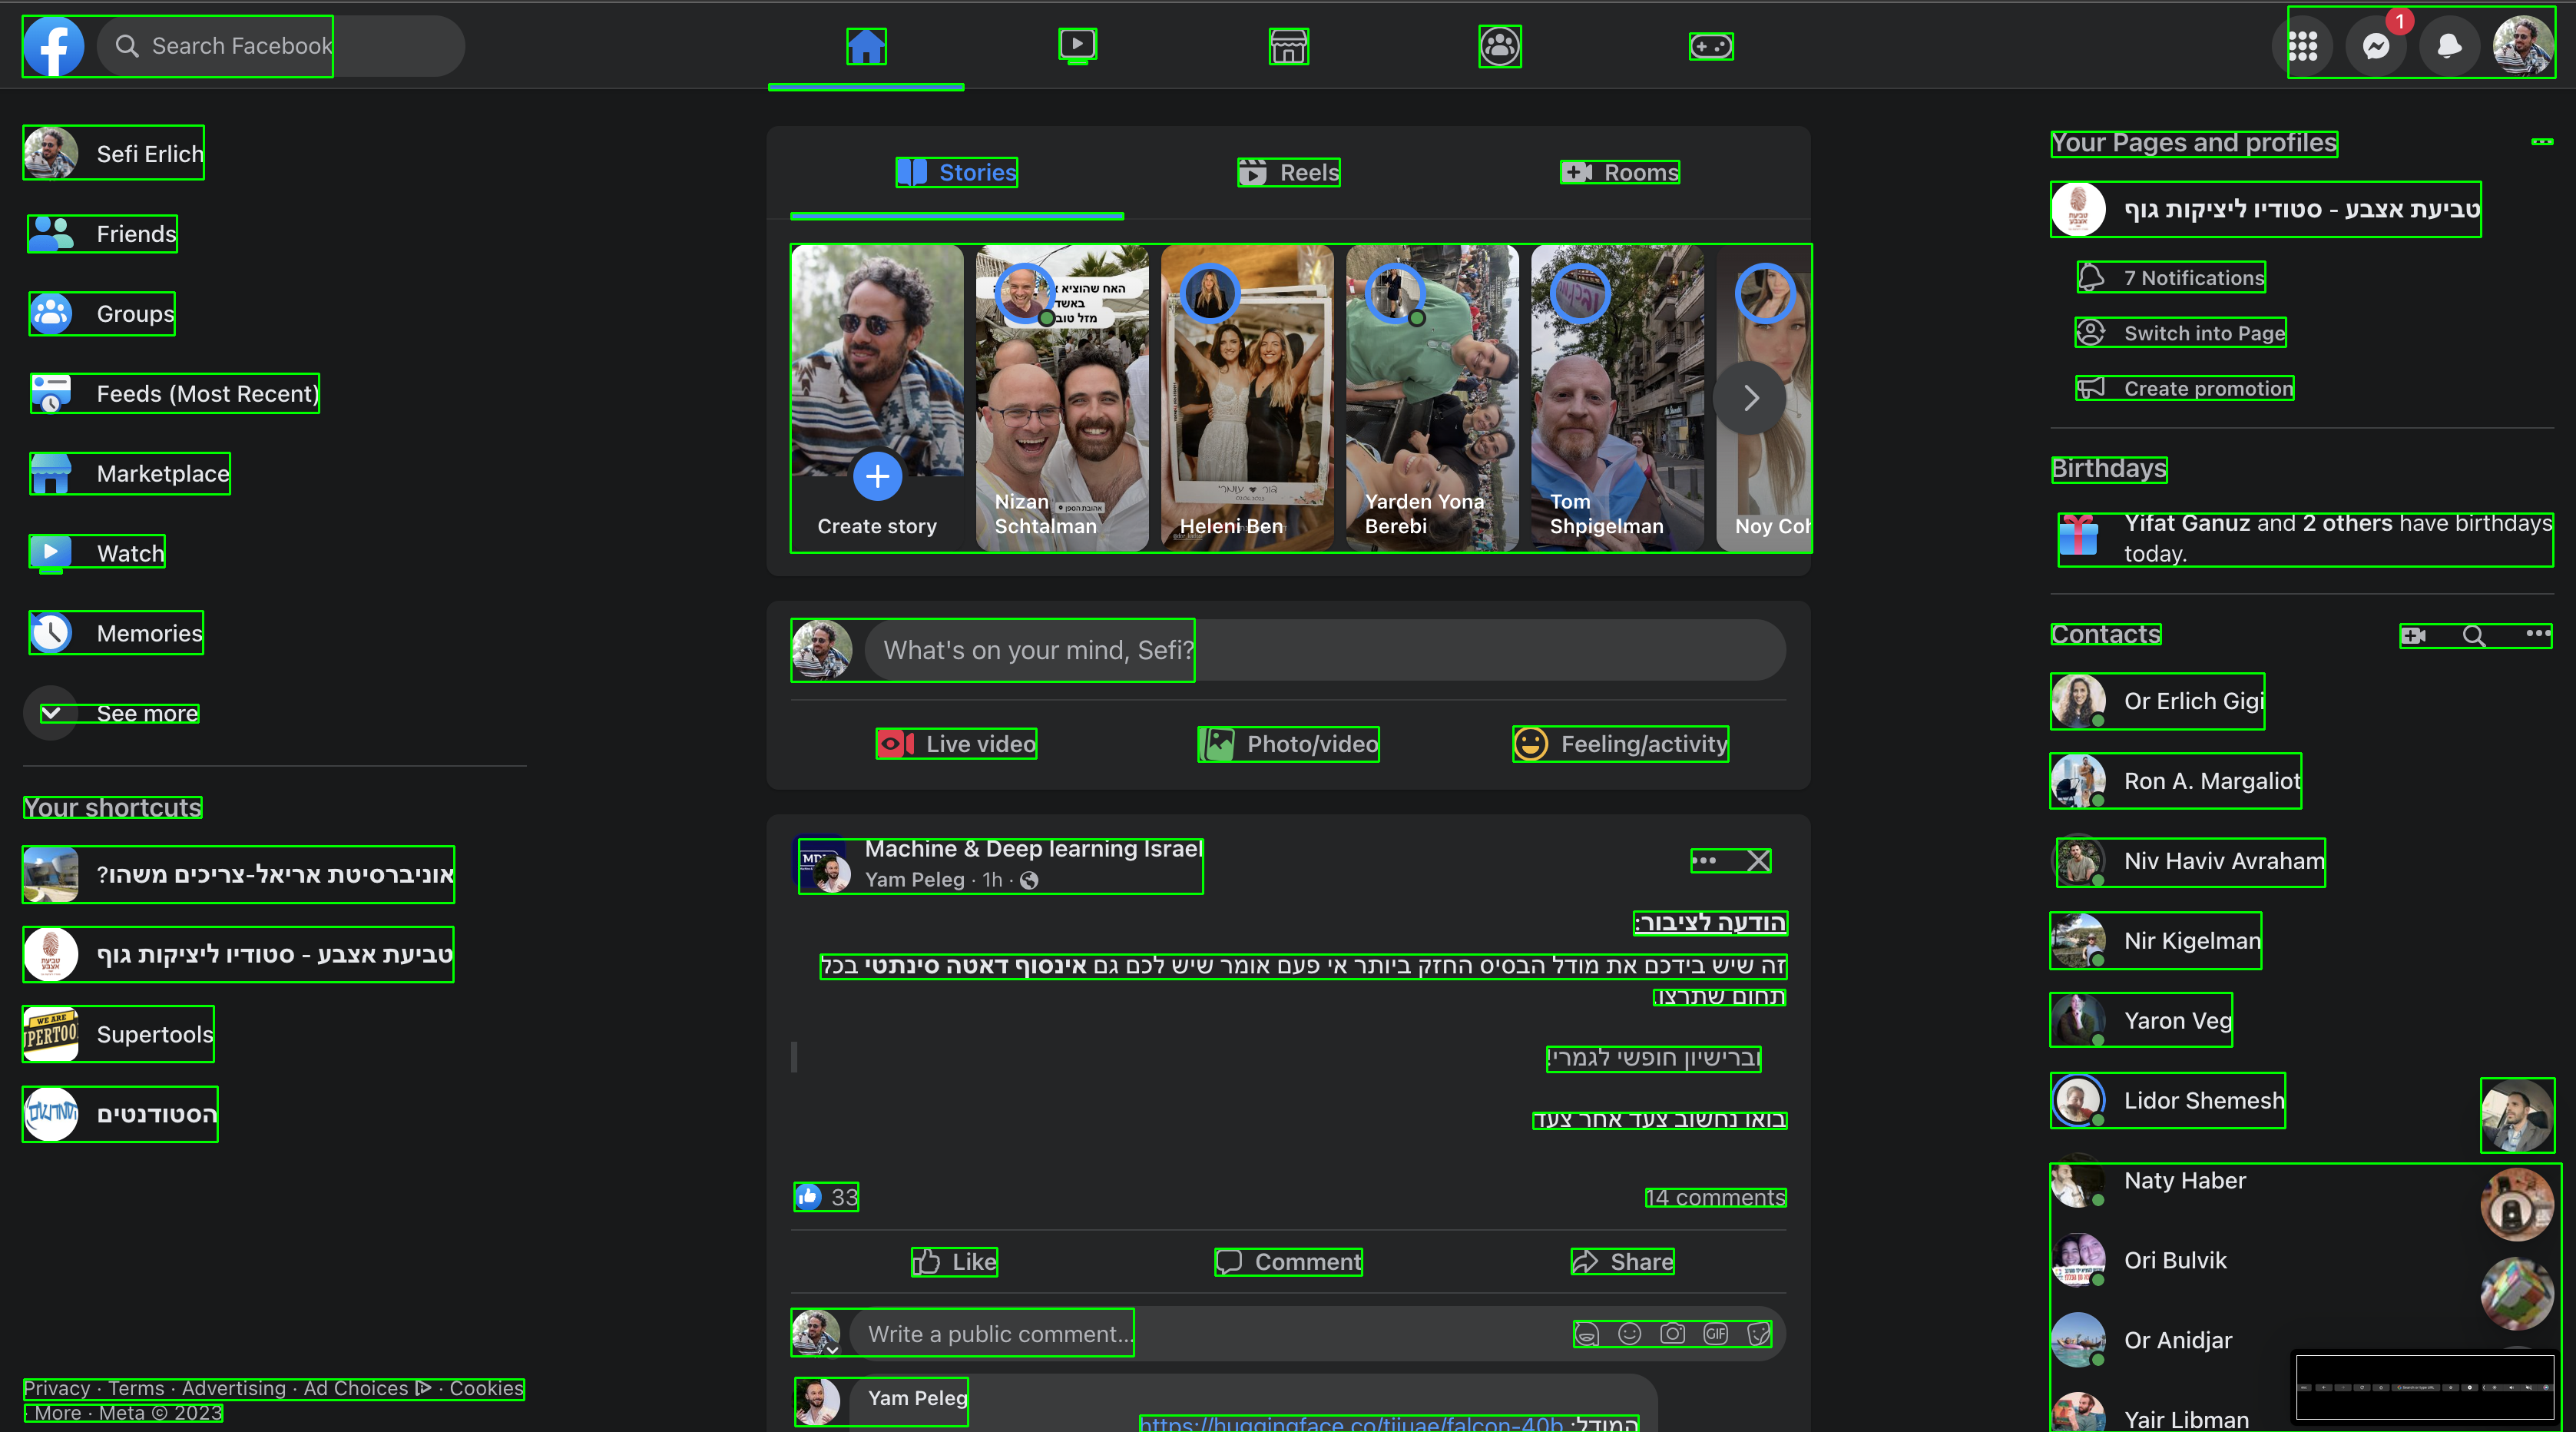

In [11]:
import cv2
import numpy as np

def merge_boxes(bounding_boxes, merge_threshold, merge_contain=True):
    # if merge_threshold == 0:
    #   return bounding_boxes

    merged_boxes = []

    while len(bounding_boxes) > 0:
        current_box = bounding_boxes[0]
        remaining_boxes = []

        for box in bounding_boxes[1:]:
            # Check for intersection or horizontal proximity between current box and other boxes
            if merge_contain and is_contains(current_box, box):
                # Merge the boxes if there is an intersection or horizontal proximity
                current_box = merge(current_box, box)
            elif is_intersecting(current_box, box) or is_intersecting(box, current_box):
                current_box = merge(current_box, box)
            elif merge_threshold != 0 and (is_close_horizontal(current_box, box, merge_threshold) or is_close_horizontal(box, current_box, merge_threshold)):
                # Add the box to the list of remaining boxes
                current_box = merge(current_box, box)
            else:
                remaining_boxes.append(box)

        # Add the merged box to the list of final boxes
        merged_boxes.append(current_box)

        # Update the bounding boxes list
        bounding_boxes = remaining_boxes

    return merged_boxes

def is_intersecting(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Check for intersection using x, y, width, and height values
    if x1 < x2 + w2 and x2 < x1 + w1 and y1 < y2 + h2 and y2 < y1 + h1:
        return True

    return False

def is_contains(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Check if box2 is completely contained within box1
    if x1 <= x2 and y1 <= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
        return True

    return False


def is_close_horizontal(box1, box2, merge_threshold):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Check for horizontal proximity using x, y, width, and merge threshold
    if abs(x1 + w1 - x2) <= merge_threshold and y1 < y2 + h2 and y2 < y1 + h1:
        return True

    return False

def merge(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate the coordinates and dimensions of the merged box
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y

    return x, y, w, h

def detect_regions(image_path, merge_threshold,canny_lower=50,canny_higer=150,merge_contain=True):
    # Load the screenshot image
    image = cv2.imread(image_path)
    print(image.shape)
    num_of_pixels = image.shape[0]*image.shape[1]
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred, canny_lower, canny_higer)

    # Find contours of the regions
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a list of bounding boxes around the regions
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    bounding_boxes = list(filter(lambda x:x[2]*x[3]<num_of_pixels/3,bounding_boxes))
    # Merge the bounding boxes recursively until there is no intersection on the horizontal axis
    merged_boxes = None
    bounding_boxes = bounding_boxes.copy()
    while merged_boxes is None or num_of_box_enterd != num_of_boxes_exit:
      print(f"Number of boxes enter {len(bounding_boxes)}")
      num_of_box_enterd = len(bounding_boxes)
      merged_boxes = merge_boxes(bounding_boxes, merge_threshold,merge_contain=merge_contain)
      num_of_boxes_exit =  len(merged_boxes)
      bounding_boxes = merged_boxes.copy()
      print(f"Number of boxes exits {len(merged_boxes)}")
      

    # Draw merged bounding rectangles around the regions
    for box in merged_boxes:
        x, y, w, h = box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with detected and merged regions
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Provide the path to your screenshot image
screenshot_path = "screen.png"

# Set the merge threshold (number of units for proximity)
merge_threshold = 100
canny_lower = 50
canny_higer = 150
merge_contain = True
# Call the function to detect and display the merged regions
detect_regions(screenshot_path, merge_threshold,canny_lower=canny_lower,canny_higer=canny_higer,merge_contain=merge_contain)


(1864, 3354, 3)
Number of boxes enter 1376
Number of boxes exits 115
Number of boxes enter 115
Number of boxes exits 28
Number of boxes enter 28
Number of boxes exits 27
Number of boxes enter 27
Number of boxes exits 27


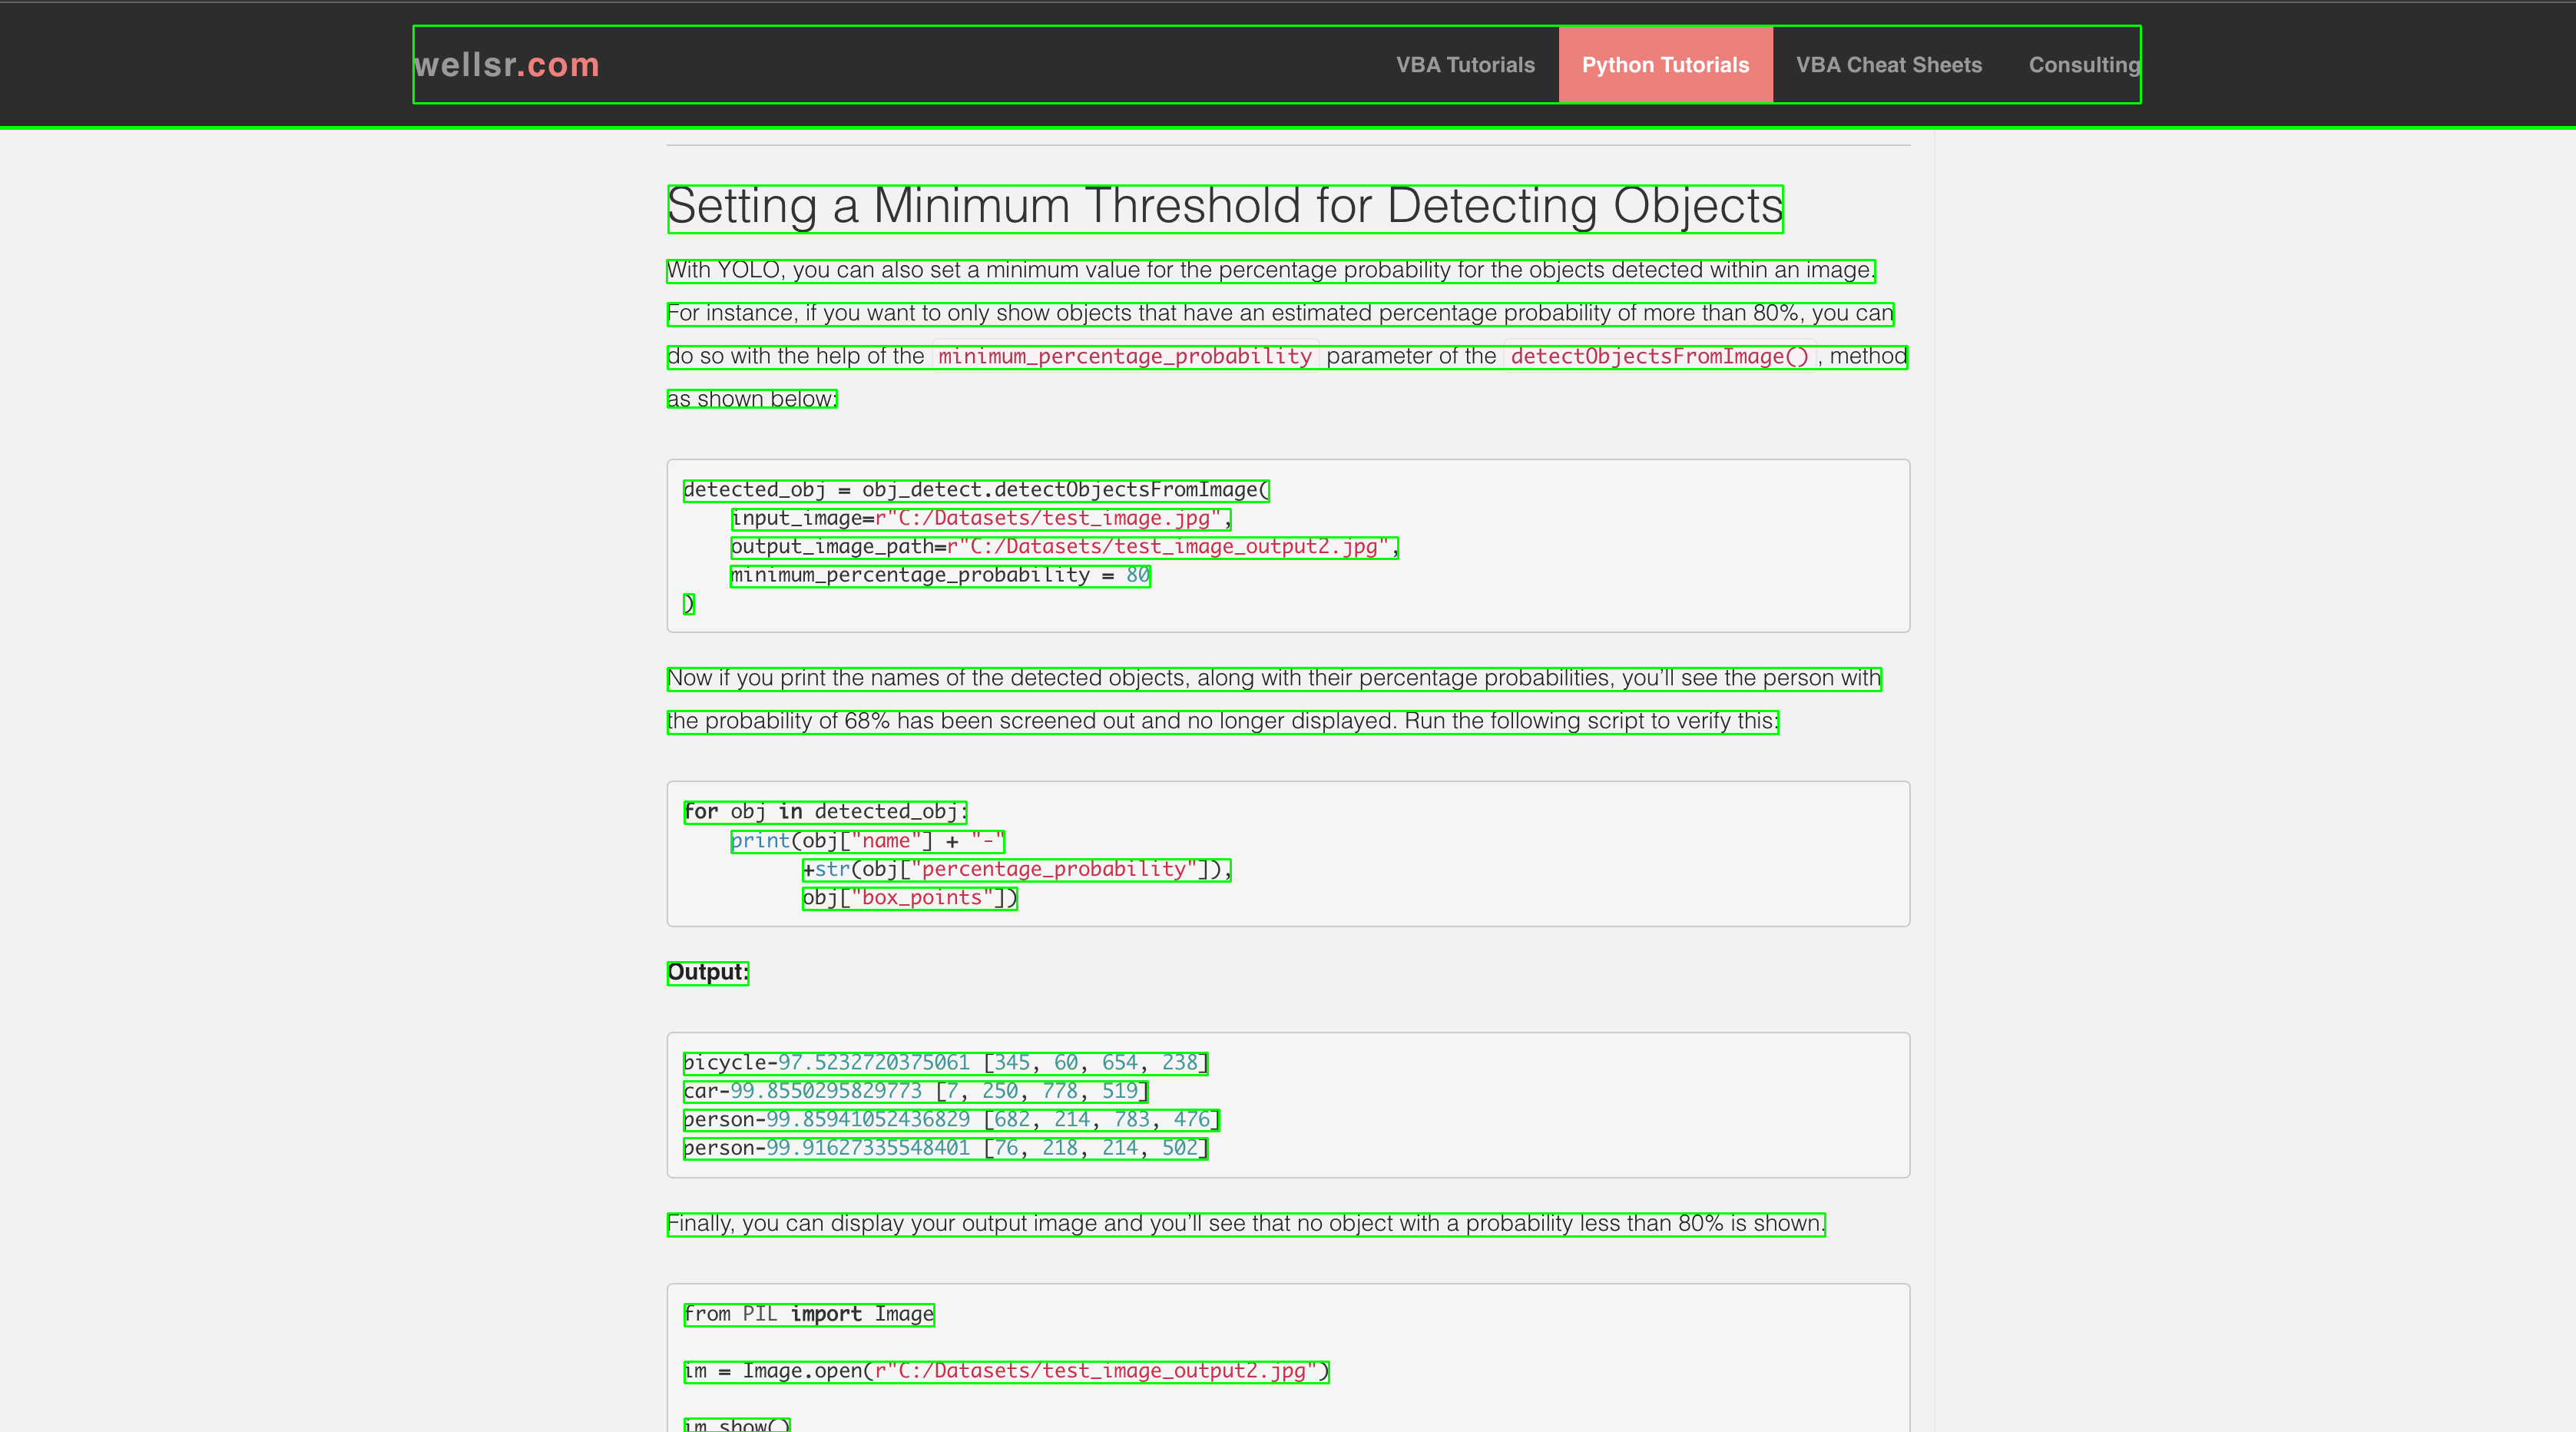

In [12]:
detect_regions("screen1.png", merge_threshold,canny_lower=canny_lower,canny_higer=canny_higer,merge_contain=merge_contain)


(1864, 3354, 3)
Number of boxes enter 918
Number of boxes exits 121
Number of boxes enter 121
Number of boxes exits 60
Number of boxes enter 60
Number of boxes exits 58
Number of boxes enter 58
Number of boxes exits 58


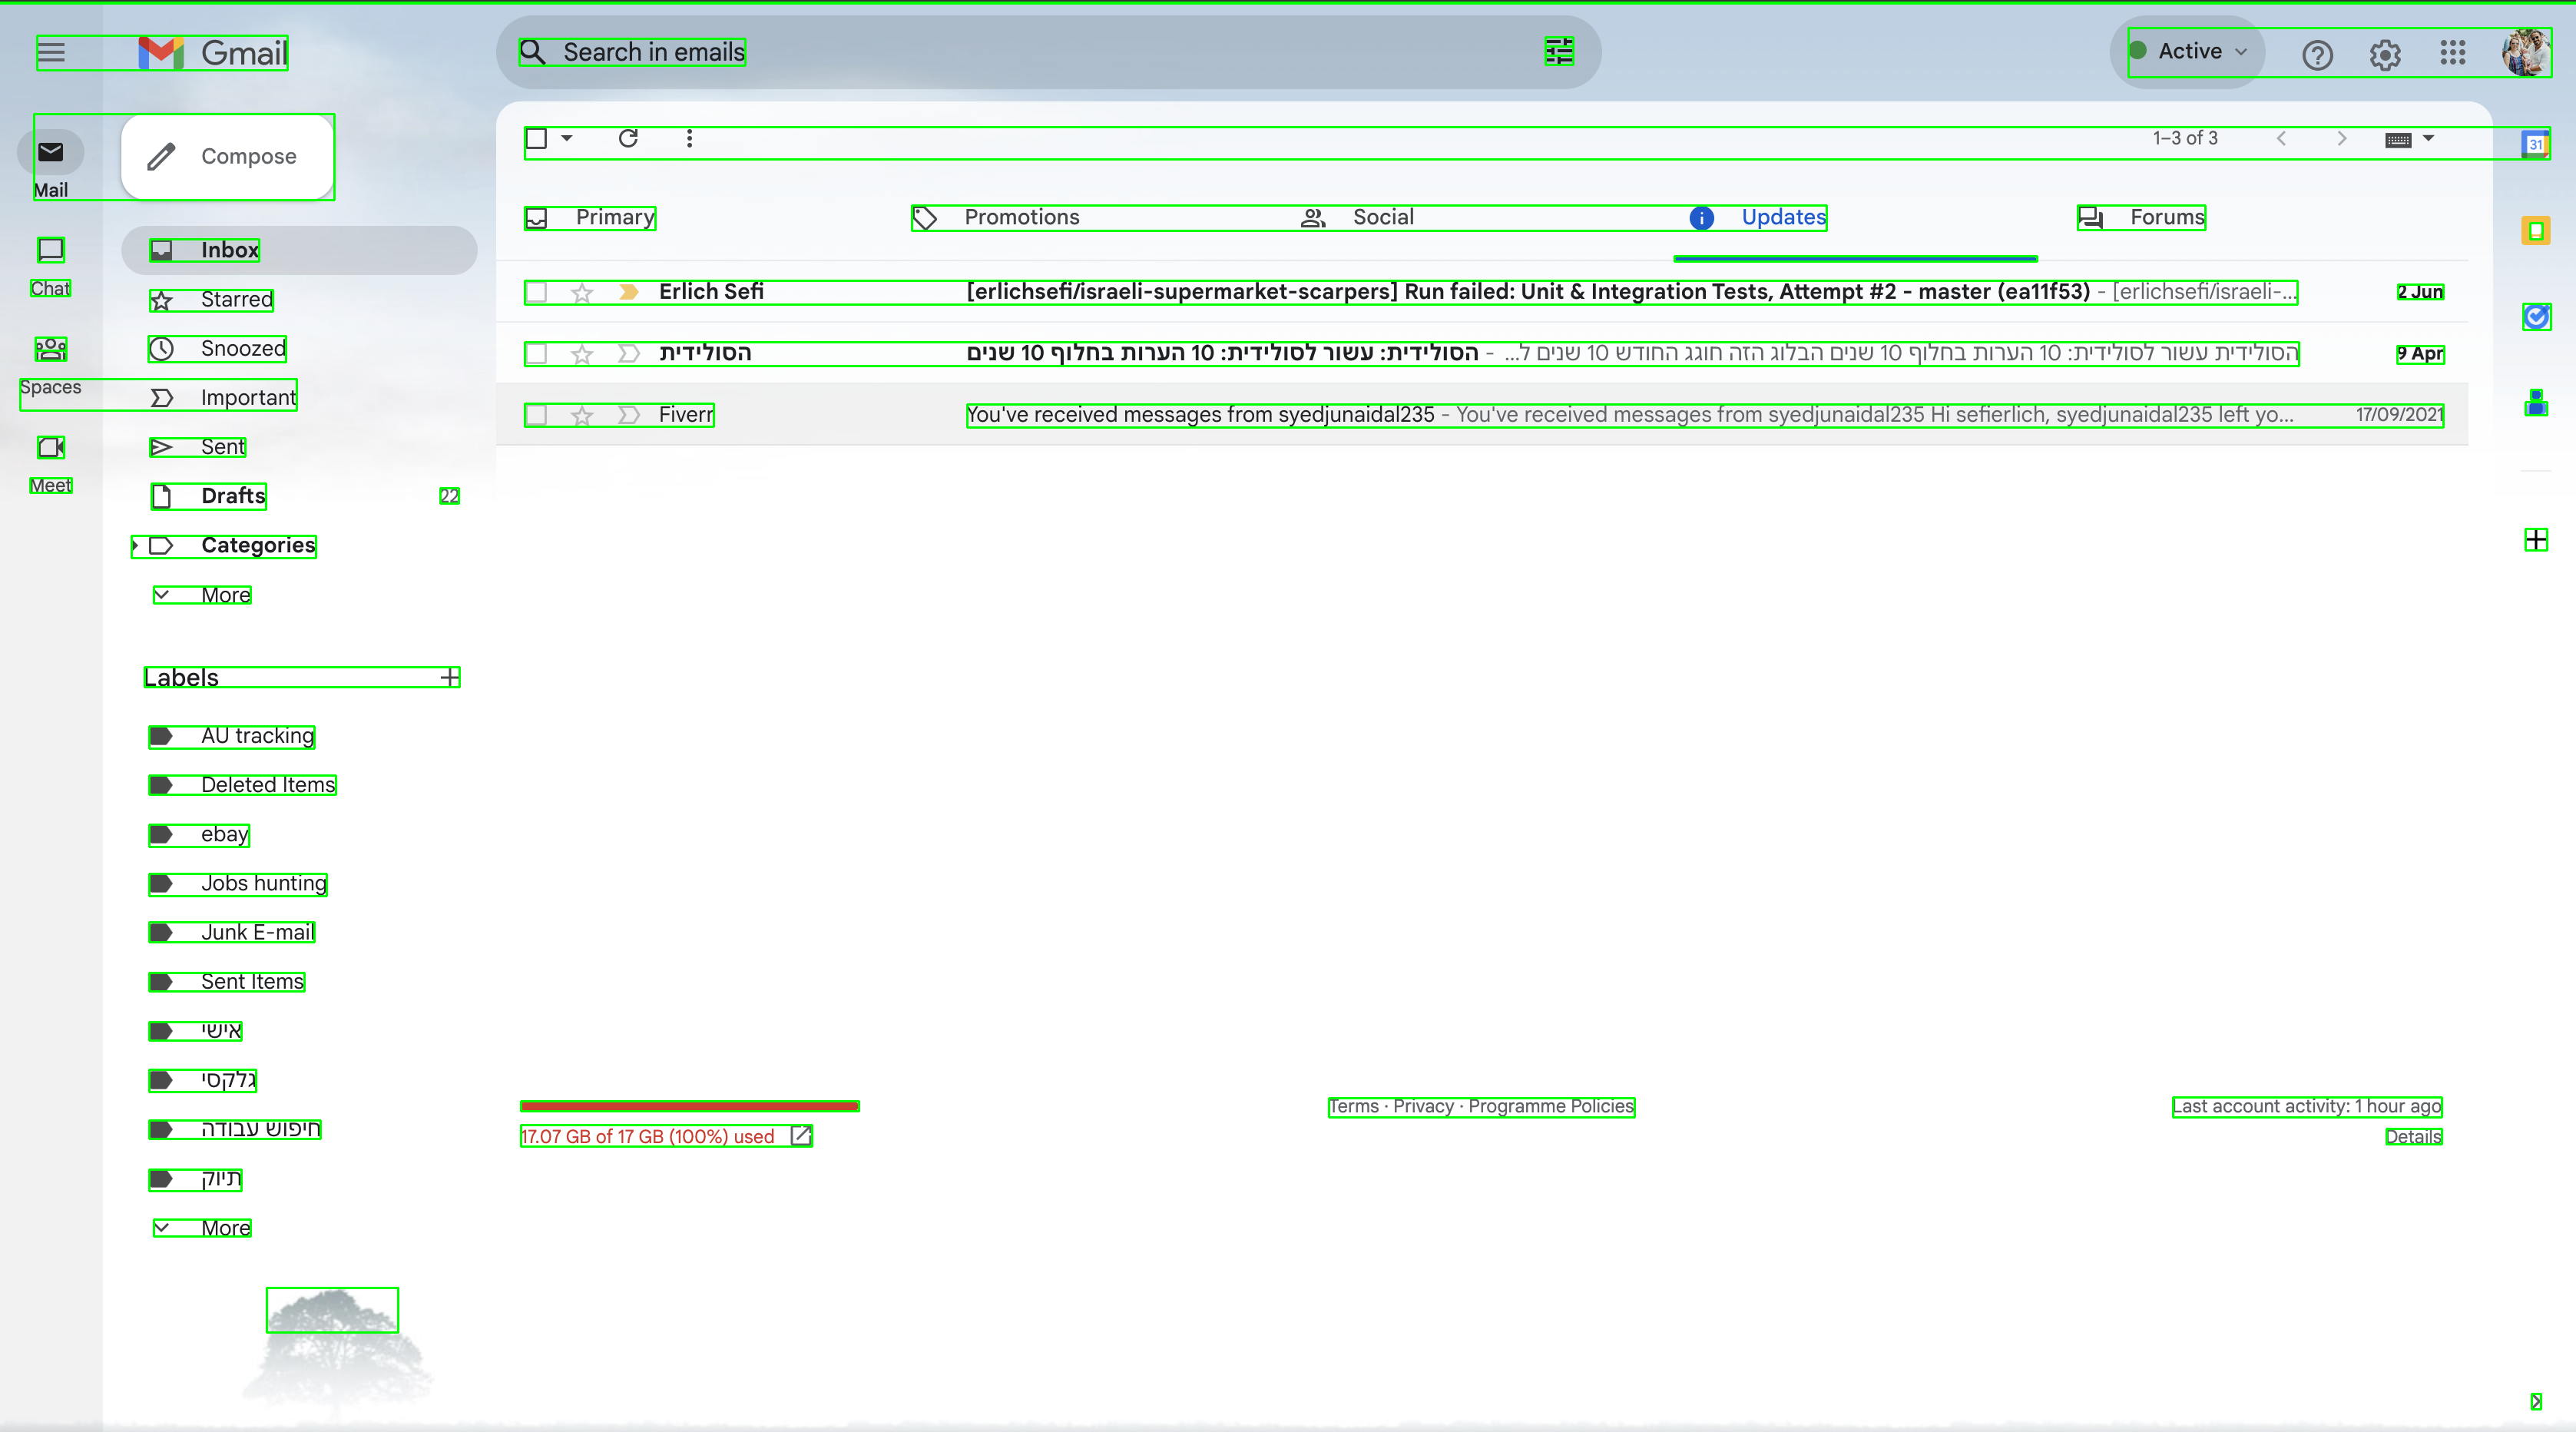

In [13]:
detect_regions("screen2.png", merge_threshold,canny_lower=canny_lower,canny_higer=canny_higer,merge_contain=merge_contain)


(1864, 3354, 3)
Number of boxes enter 2512
Number of boxes exits 472
Number of boxes enter 472
Number of boxes exits 71
Number of boxes enter 71
Number of boxes exits 58
Number of boxes enter 58
Number of boxes exits 58


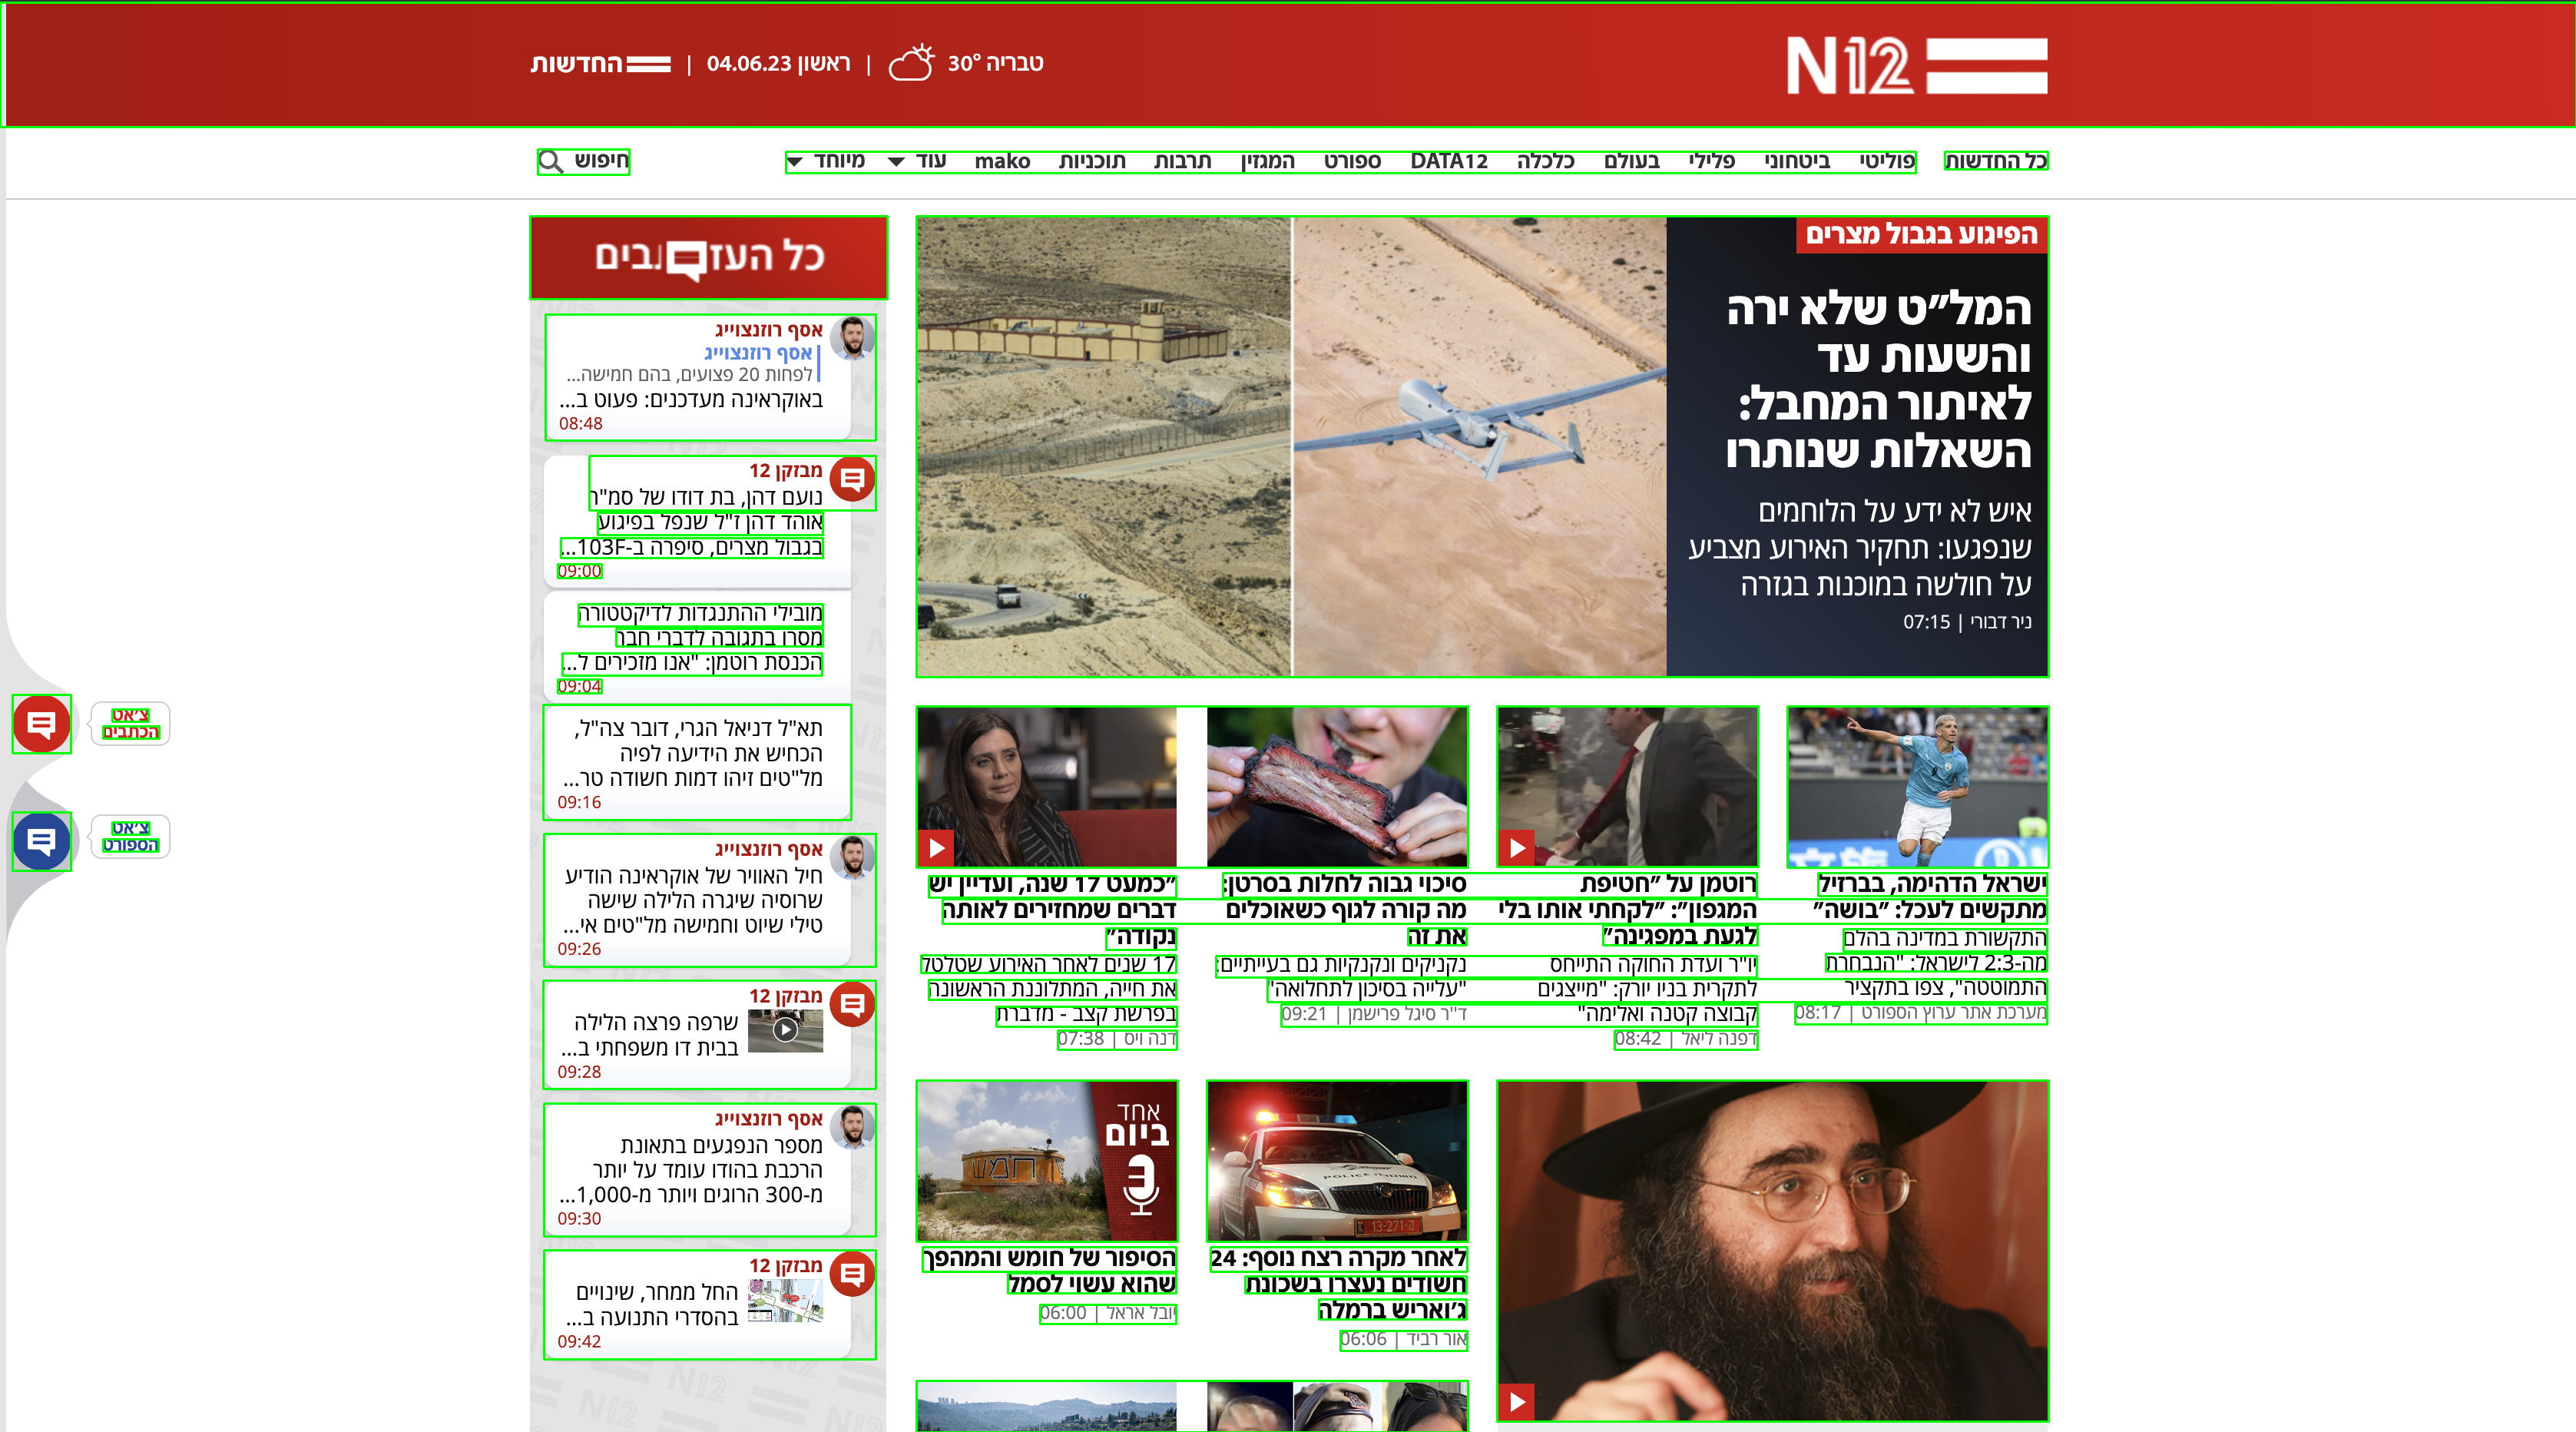

In [22]:
detect_regions("screen3.png", 30, canny_lower=canny_lower, canny_higer=canny_higer,merge_contain=True)